In [97]:
import numpy as np 
import torch 
import torch.nn as nn
from matplotlib import pyplot as plt 

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Device = {device}')

Device = cuda


In [98]:
def delta(x, x0):
    """Numerical Dirac delta function at x0
    """
    beta = 0.01
    exp = np.exp(-(x-x0)**2 / beta)
    return exp / np.sqrt(np.pi * beta)
    
def ricker(t, f0):
    """Ricker wavelet
    """
    sigma = 1 / (np.pi * f0 * np.sqrt(2))
    t0 = 6 * sigma
    tmp = np.pi**2 * f0**2 * (t-t0)**2 
    w = (1 - 2*tmp) * np.exp(-tmp)
    return w 

def source(X, x0=0.5, f0=10):
    x = X[:, 0:1]
    t = X[:, 1:2]
    w = ricker(t, f0)
    d = delta(x, x0)
    return w * d

In [99]:
# Generate data
n_samples = 10000
X = np.random.rand(n_samples, 2)
F = source(X)

In [100]:
# Train test split
idx = np.arange(n_samples)
np.random.shuffle(idx)
idx_train = idx[:int(n_samples*0.7)]
idx_test = idx[int(n_samples*0.7):]
X_train = X[idx_train]
F_train = F[idx_train]
X_test = X[idx_test]
F_test = F[idx_test]

In [101]:
# Data normalization
mx = X_train.mean(axis=0, keepdims=True)
sx = X_train.std(axis=0, keepdims=True)
mf = F_train.mean()
sf = F_train.std()
X_train = (X_train - mx) / sx 
F_train = (F_train - mf) / sf
X_test = (X_test - mx) / sx

In [102]:
class DNN(nn.Module):
    """Fully connected neural network
    """
    def __init__(self, layer_sizes):
        super(DNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

    def forward(self, x):
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x 
    
    def predict(self, X):
        self.eval()
        Y_pred = self.forward(X)
        Y_pred = Y_pred.detach().cpu().numpy()
        return Y_pred

In [103]:
def computer_mse_loss(Y_pred, Y_train):
    assert Y_pred.shape == Y_train.shape
    return torch.mean(torch.square(Y_pred-Y_train))

In [108]:
layer_sizes = [2] + [128]*5 + [1]
lr = 0.001
max_niter = 1001

dnn = DNN(layer_sizes)
dnn.to(device)

optimizer = torch.optim.Adam(
    dnn.parameters(),
    lr=lr
)

train_error = []
test_error = []

# Train
for niter in range(max_niter):
    F_pred = dnn(torch.tensor(X_train, dtype=torch.float32, device=device))
    lt = computer_mse_loss(F_pred, torch.tensor(F_train, dtype=torch.float32, device=device))
    train_error.append(lt.item())
    with torch.no_grad():
        F_pred = dnn(torch.tensor(X_test, dtype=torch.float32, device=device))
        F_pred = F_pred * sf + mf
        lv = computer_mse_loss(F_pred, torch.tensor(F_test, dtype=torch.float32, device=device))
        test_error.append(lv.item())
    optimizer.zero_grad()
    lt.backward()
    optimizer.step()

    if niter % 100 == 0 or niter == max_niter - 1:
        print('Iter %d, Loss %.4e' % (niter, lt))

Iter 0, Loss 1.0179e+00
Iter 100, Loss 9.9945e-01
Iter 200, Loss 9.9645e-01
Iter 300, Loss 9.9247e-01
Iter 400, Loss 9.3120e-01
Iter 500, Loss 6.3630e-01
Iter 600, Loss 2.0337e-01
Iter 700, Loss 3.2591e-02
Iter 800, Loss 1.4158e-02
Iter 900, Loss 8.2417e-03
Iter 1000, Loss 6.1327e-03


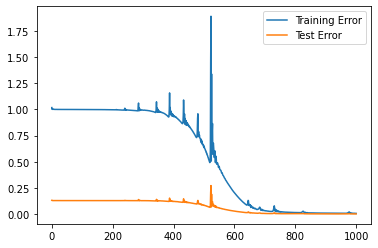

In [109]:
plt.plot(train_error, label='Training Error')
plt.plot(test_error, label="Test Error")
plt.legend()

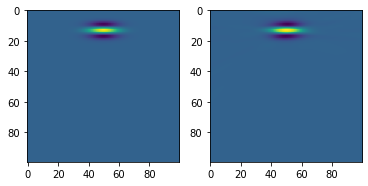

In [110]:
xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
Xs, Ys = np.meshgrid(xs, ys)
X = np.c_[Xs.flatten()[:, np.newaxis], Ys.flatten()[:, np.newaxis]]
Y_label = source(X).reshape(100, 100)
X = (X-mx) / sx
Y_pred = dnn.predict(torch.tensor(X, device=device, dtype=torch.float32))
Y_pred = (Y_pred * sf + mf).reshape(100, 100)

plt.subplot(121)
plt.imshow(Y_label)
plt.subplot(122)
plt.imshow(Y_pred)